## Predicting river depth from modern hydraulic measurements (river width)

#### E. Gabriela Gutierrez
#### Department of Geological Sciences, Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin


Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary
```
      This model's goal is to predict river depth values based on world-wide hydraulic geometry values compiled from the literature, so eventualy, users will upload their own river width measurements and river width/depth ratios (if available) to predict river depth values. 
      
      The longterm goal is eventually use large hydraulic measurement datasets generated from high resolution lidar elevation models as input of this model to predict depth/thickness river values and all type of extracted  river hydraulic geometry(channel width)data.  
   
   We will evaluate model accuracy and variance explained for two different machines while predicting river depth values as follows: First a linear regression model to predict the dept river value (response feature) from the river width (predictor A) and width/depth ratio (predictor B). Second  a linear regression model using only river width as predictor A. Third a decision tree regression using only river width as predictor A.    
```

### Import Packages

In [1]:
#General 
import numpy as np                        # to handle ndarrys when using only values within tabular data
import pandas as pd                       # to handle DataFrames, it helps tabulate data: 'Channel width (m)', 'Thickness (m)', 'Channel W/T'
import pandas.plotting as pd_plot
import os                                 # to set working directory
from scipy import stats                   # summary statistics for dataframes
import math                               # in case 'Channel width (m)' needs to be estimated
import seaborn as sns                     # for matrix scatter plots
#import scipy.signal as signal             # kernel for moving window calculation
#import random                             # for randon numbers to create

#Feature Ranking 
import matplotlib.pyplot as plt           # for plotting feture ranking plots
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression # for mutual information response/ predictor
from sklearn import preprocessing

#Model: Linear Regression
from scipy import linalg                  # for linear regression
from sklearn.linear_model import LinearRegression # linear regression model
from sklearn import linear_model
#Visualization: Linear Regression
import json #standard text-based format for representing structured data based on JavaScript object syntax
import folium #makes it easy to visualize data that's been manipulated in Python on an interactive leaflet map
from folium.plugins import MarkerCluster, HeatMap 

#Mode2: Decision Tree
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from subprocess import check_call
from sklearn.model_selection import train_test_split      # train and test split
from sklearn.metrics import mean_squared_error

#Standard package for stats 
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python  


### Load Data

The following workflow applies the .csv file 'Milliken_ea_GEOSPHERE_Quaternary_database-converted.csv', literature compiled dataset by Milliken et al., 2018. The dataset is publically available [here](https://pubs.geoscienceworld.org/gsa/geosphere/article/14/2/749/529015/Application-of-fluvial-scaling-relationships-to)  

We will work with the following features: 

* **Channel width (m)** - river width measured and compiled from literature
* **Thickness (m)** - Thickness/depth determined from wells and measured in rivers 
* **Channel W/T** - unitless ratio width and depth determined in paper.

```python
os.chdir(r'D:\Users\Gaby\Box Sync\PhD\Pyrcz Github\GeoDataSets-master') # set the working directory
df = pd.read_csv("filename.csv")                    # load the comma delimited data file
df1=df[['Thickness (m)','Channel width (m)', 'Channel W/T']]# copy all rows and columns with data of interest

```

In [2]:
os.chdir(r'D:\Users\Gaby\Box Sync\PhD\Pyrcz Github\GeoDataSets-master') # set the working directory

In [3]:
df0 = pd.read_csv('PGE3PGE383_Project_Evelin_Gutierrez_data1.csv')# load csv file 
df=df0[df0["Age"]=='Holocene'][['Thickness (m)','Channel width (m)', 'Channel W/T','Age']]
df.head(n=5)    # table preview

,Thickness (m),Channel width (m),Channel W/T,Age
0,8,40,5,Holocene
1,14,210,15,Holocene
2,14,160,11,Holocene
3,14,170,12,Holocene
4,14,275,20,Holocene


### Functions
EXTFUNC has all functions that have been used accross the course and created by external authors, which will be used in the Data preparation and Linear Regression workflow:

Partial correlation: partial correlation used in feature ranking 
visualize_model: visualize the one response and two predictor features 

PS: Canvas did not allow me to upload .py files so I sent these files via email and canvas email

In [4]:
#Partial Correlation in Python (clone of Matlab's partialcorr)
#This uses the linear regression approach to compute the partial correlation 
#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#Semipartial Correlation in Python
#This uses the linear regression approach to compute the semipartial correlation 
#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net modified by Michael Pyrcz
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com


def semipartial_corr(C): 
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#Visualize model in Python: This function was used to visualize a model with two predictor features
#Date:Fall 2020 
#Author: Michael Pyrcz


def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels = 50) # plot the predictions
    # add the data values as a colored by response feature scatter plot
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="white")
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)



EXTFUNC_Dtree has all functions that have been used accross the course and created by external authors, which will be used in the Decision Tree workflow:

In [5]:

#This function was used to evaluate the performance of the decision tree
#Date:Fall 2020 
#Author: Michael Pyrcz

def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    #plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    

## River depth/thickness prediction 

1. Basic Data Checking, Visualization and feature selection:
```
    1.1 Univariate Distributions
    1.2 Bivariate Distributions
    1.3 Pairwise Covariance
    1.4 Pairwise Correlation Coefficient
    1.5 Pairwise Spearman Rank Correlation Coefficient
    1.6 Semipartial Correlation Coefficient
    1.7 Feature ranking plots
    1.8 Mutual information 
    1.9 Beta coefficients    
```    
2. Linear Regression with two Predictors:
```
Predictors X:'Channel width (m)', 'Channel W/T'
Response y: Thickness (m)
```
```
    2.1. Create dataframe :
    2.2. Instantiate the Model & Fit the Data on Training Data
    2.3. Print the model parameters 
    2.4. Predictions using the training dataset,Goodness of fit, Plot
    2.5. Results: Predictions using testing dataset,Goodness of fit, Plot 
```
3. Linear Regression with One Predictor:
```
Predictor X:'Channel width (m)'
Response y: Thickness (m)
```
```
    3.1. Create dataframe :
    3.2. Instantiate the Model & Fit the Data on Training Data
    3.3. Print the model parameters 
    3.4. Predictions using the training dataset,Goodness of fit, Plot
    3.5. Results: Predictions using testing dataset,Goodness of fit, Plot
```
4. Decision Tree with One Predictor:
```
Predictor X:'Channel width (m)'
Response y: Thickness (m)
```
```
    4.1. Create dataframe :
    4.2. Instantiate the Model & Fit the Data on Training Data 
    4.3. Make predictions using the training& testing dataset, Goodness of fit, Plot
    4.4. Results 
```    
5. Parting comments

### 1. Data preparation and feature selection

#### 1.1 Univariate Distributions
Ocular inspection of each one of the features allows to recognize:
```
-outliers
-negative values 
```

Allows to plot histrograms with each feature

```

GSLIB.hist_st(df['Channel width (m)'].values,0,2000,log=False,cumul=False,
bins=20,weights = None,xlabel='Channel width (m)',title='Channel width (m)')


```

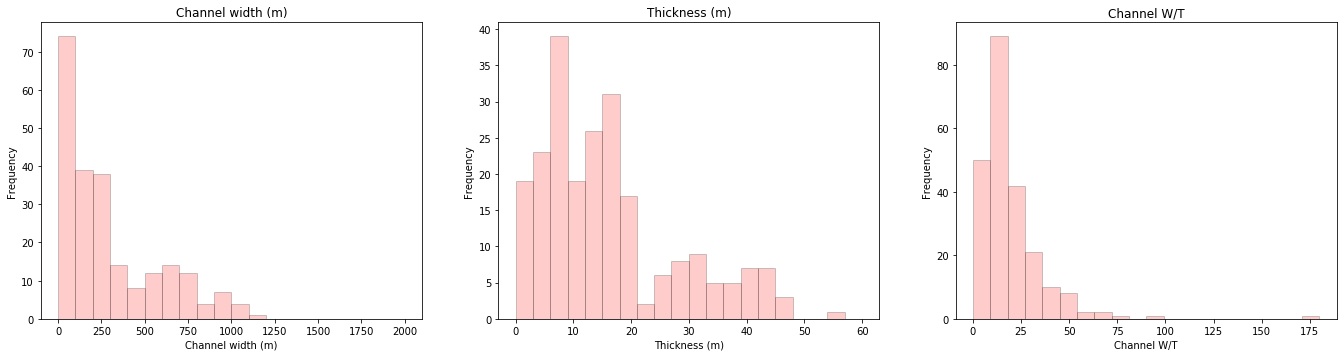

In [6]:
plt.subplot(331)
GSLIB.hist_st(df['Channel width (m)'].values,0,2000,log=False,cumul = False,bins=20,weights = None,xlabel='Channel width (m)',title='Channel width (m)')

plt.subplot(332)
GSLIB.hist_st(df['Thickness (m)'].values,0,60,log=False,cumul = False,bins=20,weights = None,xlabel='Thickness (m)',title='Thickness (m)')

plt.subplot(333)
GSLIB.hist_st(df['Channel W/T'].values,0,180,log=False,cumul = False,bins=20,weights = None,xlabel='Channel W/T',title='Channel W/T')



plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

#### 1.2 Bivariate Distributions
Since the Linear Regression method relies on the assumption of pairwise feature linearity, we check the matrix scatter plot. 

* the pariwise relationships appear to be linear. However, only one Thickness vs Channel W/T is homoscedastic. Thickness vs Channel width shows heteroscadicity after 30m thickness, 500 m width. 

```python
sns.pairplot(df,vars=['Thickness (m)','Channel width (m)','Channel W/T'],markers='o') # matrix scatter plot
```

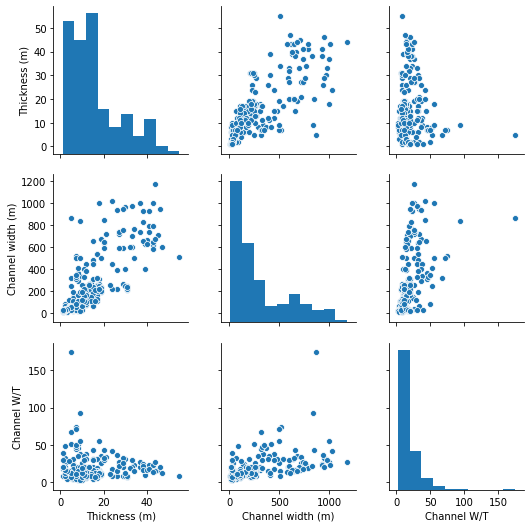

In [7]:
sns.pairplot(df,vars=['Thickness (m)','Channel width (m)','Channel W/T'],markers='o');

#### 1.3 Pairwise Covariance 
measure of the strength of the linear relationship between:
```
'Channel width (m)', 'Channel W/T' (predictor features)
'Thickness (m)'(response feature)
```

In [8]:
covariance = df.loc[:,['Thickness (m)','Channel width (m)', 'Channel W/T']].cov().iloc[0,1:3]
print(covariance)

Channel width (m)    2520.912304
Channel W/T            -9.228783
Name: Thickness (m), dtype: float64


#### 1.4 Pairwise Correlation Coefficient
measure of the strength of the linear relationship between but removes the sensitivity to the dispersion / variance 
```
Normalized:

'Channel width (m)', 'Channel W/T' (predictor features)
'Thickness (m)'(response feature)
```

In [9]:
correlation = df.loc[:,['Thickness (m)','Channel width (m)', 'Channel W/T']].corr().iloc[0,1:3]
print(correlation)

Channel width (m)    0.750810
Channel W/T         -0.044632
Name: Thickness (m), dtype: float64


Full correlation matrix to evaluate: 
```
potential for redudancy between predictor features.
```

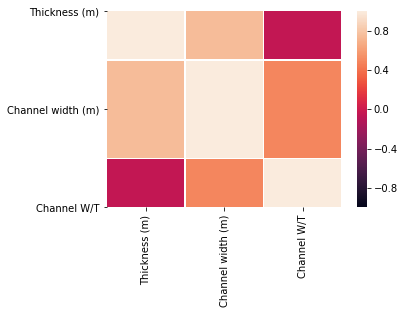

In [10]:
plt.subplot(221)                          # plot a color coded correlation matrix
sns.heatmap(df.loc[:,['Thickness (m)','Channel width (m)', 'Channel W/T']].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

#### 1.5 Pairwise Spearman Rank Correlation Coefficient
The goal is to address outliers and it also relaxes the linear assumption


In [11]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.loc[:,['Thickness (m)','Channel width (m)','Channel W/T']]) # calculate the range correlation coefficient
rank_correlation = rank_correlation[:,0][1:3]
rank_correlation_pval = rank_correlation_pval[:,0][1:3]
print('Channel width,Channel W/T', rank_correlation)
print('Channel width,Channel W/T', rank_correlation_pval)

Channel width,Channel W/T [0.79551837 0.13628259]
Channel width,Channel W/T [7.38889562e-51 4.02133930e-02]


```
The correlation improved for both indicating outliers presence in Channel width
Channel W/T shows improvement by reaxing the linear relationship and outliers
```

####  1.6 Semipartial Correlation Coefficient
linear relationship between each predictor 'Channel width (m)','Channel W/T' and the response'Thickness (m)' while controlling for the effect of the not considered feeture


In [12]:
partial_correlation = partial_corr(df.loc[:,['Thickness (m)','Channel width (m)','Channel W/T']]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,0][1:3] # extract a single row and remove production with itself
print('Channel width,Channel W/T',partial_correlation)

Channel width,Channel W/T [ 0.85964126 -0.51006082]


```
the correlation improved for 'Channel width' by removing the effect of Channel W/T
the correlation decreased for Channel W/T by removing the effect of 'Channel width'

'Channel width' shows a stronger correlation.
```

#### 1.7 Feature ranking plots


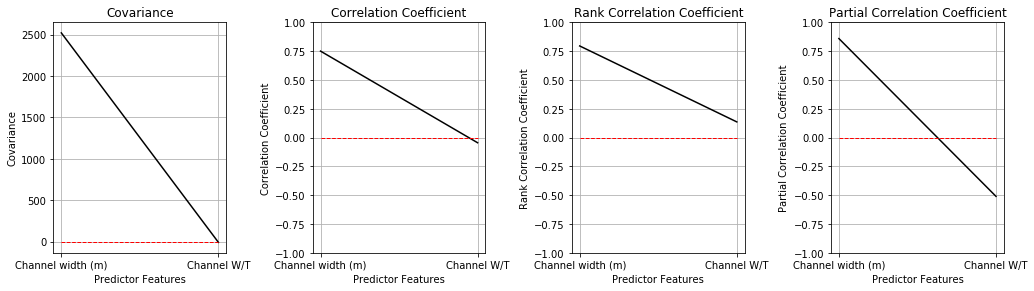

In [13]:
features = df.columns.values[0:][1:3]
plt.subplot(141)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
#plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(142)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(143)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(144)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)



plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.8, wspace=0.5, hspace=0.1)
plt.show()

#### 1.8 Mutual information 

Generalized approach that quantifies the mutual dependence between:
```
'Channel width (m)' (predictor features) and 'Thickness (m)'(response feature)
'Channel W/T' (predictor features)and 'Thickness (m)'(response feature)
```
We are required to run coefficients that evaluate how much information provide the predictors about the response feature in this case we relax the assumption of predictor-response linear relationship.   

Feature ranking:
1. feature Channel width (m) = 1.000000
2. feature Channel W/T = 0.383051


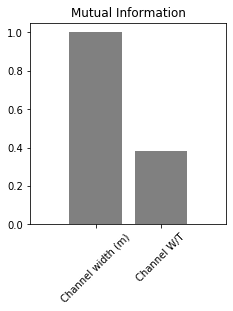

In [14]:
x = df[['Channel width (m)', 'Channel W/T']]              # separate DataFrames for predictor and response features
y = df[['Thickness (m)']]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(121)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="gray", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=45)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=0.7, wspace=0.2, hspace=0.2)
plt.show()

*Channel width gives more information about 'Thickness (m)'(response feature) than 'Channel width (m)'

#### 1.9 Beta coefficients 

I used this coeeficients to see how well the 'Channel width (m)' and 'Channel W/T' perform in a linear regression and decision tree model, which are the models to be used in the workflow.
We need to statandarize data to a mean of 0 and variance of 1

```
dfS = pd.DataFrame()                      #creates dataframe with standarized data 
dfS['Thickness (m)'],d1,d2 = geostats.nscore(df,'Thickness (m)')#stadardization function

```
Feature standardization

In [15]:
dfS = pd.DataFrame()                      # Gaussian transform of each feature, standardization to a mean of 0 and variance of 1 
dfS['Thickness (m)'],d1,d2 = geostats.nscore(df,'Thickness (m)')
dfS['Channel width (m)'],d1,d2 = geostats.nscore(df,'Channel width (m)')
dfS['Channel W/T'],d1,d2 = geostats.nscore(df,'Channel W/T')

Beta coefficients for Linear Regression

In [16]:
linear_reg_standardized = LinearRegression().fit(dfS[['Channel width (m)', 'Channel W/T']].values,dfS[['Thickness (m)']].values)
print('Features: ' + str(dfS.columns [1:3].values))
beta = np.round(linear_reg_standardized.coef_,2)[0]
print('Beta coefficients:' + str(beta)) 

Features: ['Channel width (m)' 'Channel W/T']
Beta coefficients:[ 1.18 -0.67]


*Channel width performs better than 'Channel W/T'

Beta coefficients for Decision Tree/Feature importance

In [17]:
my_tree_standarized = tree.DecisionTreeRegressor().fit (dfS[['Channel width (m)', 'Channel W/T']].values,dfS[['Thickness (m)']].values)
print('Features: ' + str(dfS.columns [1:3].values))
print('Importances =',round(my_tree_standarized.feature_importances_[0],2),round(my_tree_standarized.feature_importances_[1],2))

Features: ['Channel width (m)' 'Channel W/T']
Importances = 0.75 0.25


* In decision Tree Channel width performs better than 'Channel W/T'

### 2. Linear Regresion: Two predictors:

I evaluated the linear regression model because it has been used as the preferred model with several hydraulic measurements (width, depth, curvature, catchment size area, etc). In general way the  However, I will demonstrate existing limitations among the predictors that can be used in such prediction due to multicolonearity    

#### 2.1 Create dataframe

In [18]:
X=df[['Channel width (m)', 'Channel W/T']] 
y=df[['Thickness (m)']]

Fair split data 20% for wihheld for testing: 

In [19]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None) # train and test split
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 181, number of test 46


#### 2. 2. Instantiate the Model & Fit the Data on Training Data: 

In [20]:
linear_reg = linear_model.LinearRegression() #Instantiate the Model 

linear_reg.fit(X_train.values, y_train.values) #Fit the Data on Training Data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### 2.3. Print the model parameters

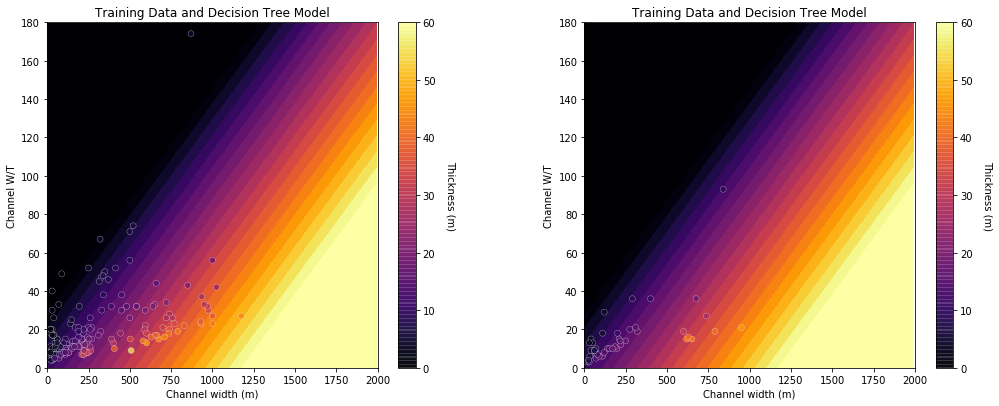

In [21]:

plt.subplot(121)
plt = visualize_model(linear_reg,X_train['Channel width (m)'],0,2000,X_train['Channel W/T'],0,180,
                      y_train['Thickness (m)'],0,60,'Training Data and Decision Tree Model')
plt.subplot(122)
plt = visualize_model(linear_reg,X_test['Channel width (m)'],0,2000,X_test['Channel W/T'],0,180,
                      y_test['Thickness (m)'],0,60,'Training Data and Decision Tree Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

####  2.4.  Predictions on Training data, Goodness of fit, Plot

Predictions on training dataset, Goodness of fit, plot

Variance explained training: 33.79
Training: Average error = -0.00
Training: Standard Deviation error = 5.81
Score:  0.771


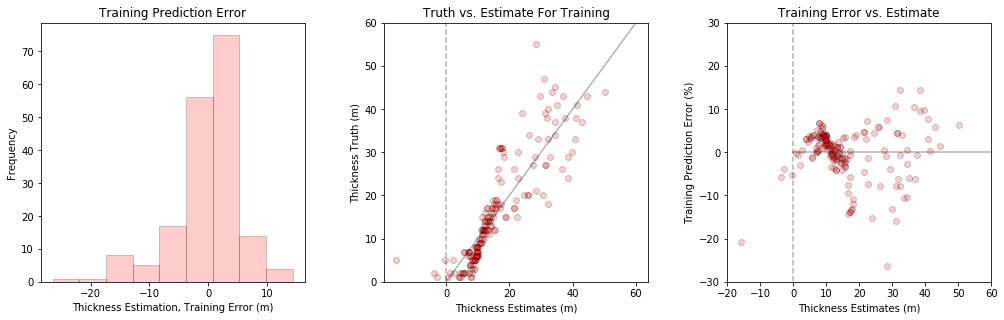

In [22]:
from sklearn.metrics import mean_squared_error
# Step 3: - Make predictions using the training dataset
y_train_pred = linear_reg.predict(X_train.values)        # predict with the trained model at the training data samples 

# Report the goodness of fit
MSE_train = mean_squared_error(y_train, y_train_pred)           # calculate the training MSE      
print('Variance explained training: %.2f' % MSE_train)

y_train_resid = y_train_pred - y_train.values     # calculate the residuals over the training data
print('Training: Average error = %.2f' % np.average(y_train_resid)) # calculate the average testing error 
print('Training: Standard Deviation error = %.2f' % np.std(y_train_resid)) # calculate the standard deviation testing error
print('Score: ', str(round(float(linear_reg.score(X_train.values, y_train)),3))) # calculate the score, valid in Linear regression


plt.subplot(131)                                                # histogram of training error
plt.hist(y_train_resid, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(y_train_resid.min(),y_train_resid.max(),10))
plt.title('Training Prediction Error'); plt.xlabel('Thickness Estimation, Training Error (m)'); plt.ylabel('Frequency')


plt.subplot(132)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train_pred,y_train.values,c='red',alpha=0.2,edgecolor='black')
plt.plot([0,60],[0,60],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); 
plt.ylim(0,60)
plt.title('Truth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred,y_train_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('Training Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Training Prediction Error (%)')
plt.plot([0,60],[0,0],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
plt.xlim(-20,60); plt.ylim(-30,30)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

#### 2.5. Results: Predictions on testing dataset, Goodness of fit, plot

Variance explained testing = 15.55
Testing: Average error = -0.20
Testing: Standard Deviation error = 3.94
Score:  0.877


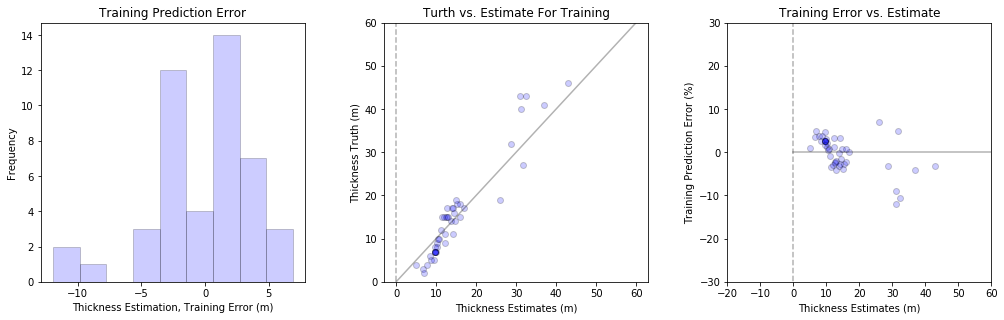

In [23]:
# Step 4: - Make predictions using the testing dataset
y_test_pred = linear_reg.predict(X_test.values)          # predict with the trained model at the training data samples 

# Report the goodness of fit
MSE_test = mean_squared_error(y_test, y_test_pred)              # calculate the testing MSE      
print('Variance explained testing = %.2f' % MSE_test)

y_test_resid = y_test_pred - y_test.values        # calculate the residuals over the testing data

print('Testing: Average error = %.2f' % np.average(y_test_resid)) # calculate the average testing error 
print('Testing: Standard Deviation error = %.2f' % np.std(y_test_resid)) # calculate the standard deviation testing error
print('Score: ', str(round(float(linear_reg.score(X_test.values, y_test)),3))) # calculate the score on testing, valid in Linear regression

plt.subplot(131)                                                # histogram of training error
plt.hist(y_test_resid, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(y_test_resid.min(),y_test_resid.max(),10))
plt.title('Training Prediction Error'); plt.xlabel('Thickness Estimation, Training Error (m)'); plt.ylabel('Frequency')
#plt.xlim(y_test_resid.min(),y_test_resid.max(),)#; plt.ylim(0,1500000)



plt.subplot(132)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test_pred,y_test.values,c='blue',alpha=0.2,edgecolor='black')
plt.plot([0,60],[0,60],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); 
plt.ylim(0,60)
plt.title('Turth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred,y_test_resid,c='blue',alpha=0.2,edgecolor='black')
plt.title('Training Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Training Prediction Error (%)')
plt.plot([0,60],[0,0],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
plt.xlim(-20,60); plt.ylim(-30,30)
#plt.xlim(0,60); plt.ylim(-20,20)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

Bivariate plots of Estimated/predicted values vs Predictors

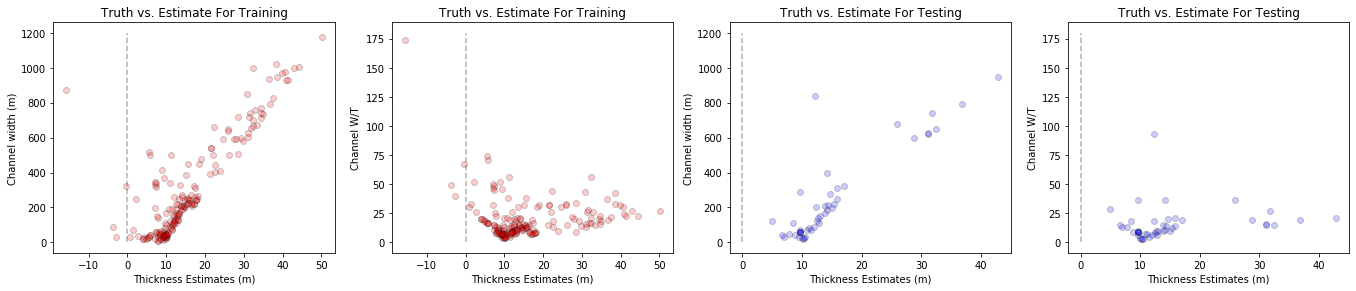

In [24]:
plt.subplot(141)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train_pred,X_train['Channel width (m)'].values,c='red',alpha=0.2,edgecolor='black')
plt.plot([0,0],[0,1200],'r--',c='black',alpha=0.3)
#plt.xlim(0,60);#plt.ylim(0,60)
plt.title('Truth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplot(142)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred,X_train['Channel W/T'].values,c='red',alpha=0.2,edgecolor='black')
plt.plot([0,0],[0,180],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Truth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel W/T')

plt.subplot(143)                                                # scatter plot predictors vs predcted 
plt.scatter(y_test_pred,X_test['Channel width (m)'].values,c='blue',alpha=0.2,edgecolor='black')
plt.plot([0,0],[0,1200],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Truth vs. Estimate For Testing'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplot(144)                                                # scatter plot predictors vs predcted  
plt.scatter(y_test_pred,X_test['Channel W/T'].values,c='blue',alpha=0.2,edgecolor='black')
plt.plot([0,0],[0,180],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Truth vs. Estimate For Testing'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel W/T')


plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=0.8, wspace=0.2, hspace=0.1)
plt.show()

These plots are key to identify that our model predicted negative depth/thickness values, indicating that our linear regression model using two predictor features is a patological model. The problem is associated with the fact that one of the predictors we used. Specifically, Channel W/T, which has a negative correlation as the correlation coefficient and partial correlation coefficient indicated during feature ranking. The workflow we are showing is a demonstration of multicolinearity between not only predictor-response feature but also amonf the predictor features.    

### 3. Linear Regresion with 1 Predictor:
Once we addressed the multicolinearity among the predictor features, we will predict thinckness/depth river values using only Channel width(m) as predictor

#### 3.1 Create dataframe

In [25]:
X1=df['Channel width (m)'] 
y1=df[['Thickness (m)']]

Fair split data 20% for wihheld for testing:

In [26]:
from sklearn.model_selection import train_test_split 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=None) # train and test split
n1_train = len(X1_train)
n1_test = len(X1_test)
print('Number of training ' + str(n1_train) + ', number of test ' + str(n1_test))

Number of training 181, number of test 46


#### 3.2 Instantiate the Model & Fit the Data on Training Data 1 Predictor

In [27]:
linear_reg1 = linear_model.LinearRegression() #Instantiate the Model 

linear_reg1.fit(X1_train.values.reshape(n1_train,1), y1_train.values, sample_weight=True) #Fit the Data on Training Data
Chwid_model = np.linspace(0,2000,n1_train)# this arrange 

#### 3.3. Model parameters, Predictions on training dataset, Goodness of fit, Plot

Variance explained training: 59.64
Training: Average error = 0.00
Training: Standard Deviation error = 7.72
Score:  0.554


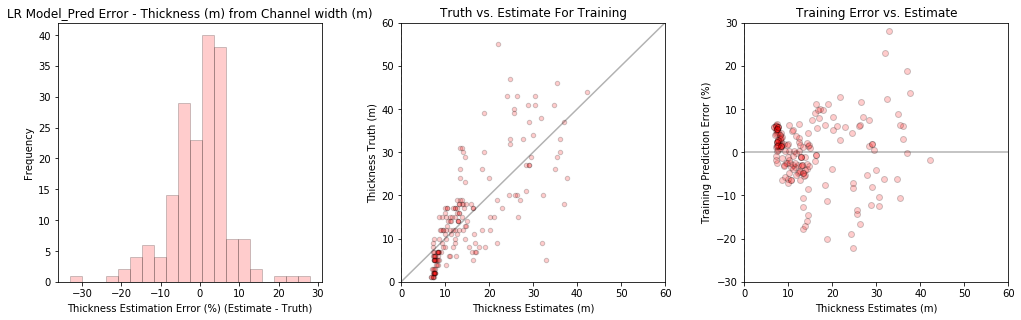

In [28]:

depth_model1 = linear_reg1.predict(Chwid_model.reshape(n1_train,1)) # predict with the fit model
y1_train_pred = linear_reg1.predict(X1_train.values.reshape(n1_train,1))

MSE_train = mean_squared_error(y1_train, y1_train_pred)           # calculate the training MSE      
print('Variance explained training: %.2f' % MSE_train)

y1_train_resid = y1_train_pred - y1_train.values     # calculate the residuals over the training data
print('Training: Average error = %.2f' % np.average(y1_train_resid)) # calculate the average testing error 
print('Training: Standard Deviation error = %.2f' % np.std(y1_train_resid)) # calculate the standard deviation testing error
print('Score: ', str(round(float(linear_reg1.score(X1_train.values.reshape(n1_train,1), y1_train)),3))) 


#plt.subplot(121)
#plt = visualize_model(linear_reg,X_train['Channel width (m)'],0,2000,X_train['Channel W/T'],0,180,
 #                     y_train['Thickness (m)'],0,60,'Training Data and Decision Tree Model')

#plt.subplot(122)
#plt = visualize_model(linear_reg,X_test['Channel width (m)'],0,2000,X_test['Channel W/T'],0,180,
 #                     y_test['Thickness (m)'],0,60,'Training Data and Decision Tree Model')

plt.subplot(131)
plt.hist(y1_train_resid, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('LR Model_Pred Error - Thickness (m) from Channel width (m)'); plt.xlabel('Thickness Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
#plt.xlim(-4,4)#; plt.ylim(0,1500000)

    
plt.subplot(132)
plt.scatter(y1_train_pred, y1_train, color='red', s = 20, alpha = 0.2,edgecolor = 'black')
plt.plot([0,60],[0,60],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
plt.title('Truth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')
plt.xlim(0,60); plt.ylim(0,60)

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y1_train_pred,y1_train_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('Training Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Training Prediction Error (%)')
plt.plot([0,60],[0,0],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
plt.xlim(0,60); plt.ylim(-30,30)

    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

#### 3.4 Results Model parameters, Predictions on testing dataset, Goodness of fit, Plot

Variance explained training: 75.35
Training: Average error = -1.91
Training: Standard Deviation error = 8.47
Score:  0.577


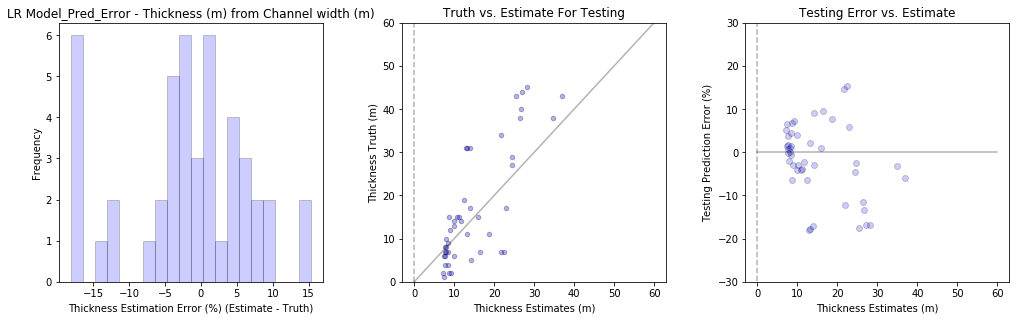

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

# Step 3: - Make predictions using the testing dataset
y1_pred = linear_reg1.predict(X1_test.values.reshape(n1_test,1))

MSE_train = mean_squared_error(y1_test, y1_pred)           # calculate the training MSE      
print('Variance explained training: %.2f' % MSE_train)

y1_test_resid = y1_pred - y1_test.values     # calculate the residuals over the training data
print('Training: Average error = %.2f' % np.average(y1_test_resid)) # calculate the average testing error 
print('Training: Standard Deviation error = %.2f' % np.std(y1_test_resid)) # calculate the standard deviation testing error
print('Score: ', str(round(float(linear_reg1.score(X1_test.values.reshape(n1_test,1), y1_test)),3))) 

# Plot testing diagnostics 

plt.subplot(131)
plt.hist(y1_test_resid, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20)
plt.title('LR Model_Pred_Error - Thickness (m) from Channel width (m)'); plt.xlabel('Thickness Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
#plt.xlim(-4,4)#; plt.ylim(0,1500000)

plt.subplot(132)
plt.scatter(y1_pred, y1_test,  color='blue', s = 20, alpha = 0.3,edgecolor = 'black')
plt.title('Truth vs. Estimate For Testing'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')
plt.plot([0,60],[0,60],c='black',alpha=0.3)
plt.plot([0,0],[0,60],'r--',c='black',alpha=0.3)
#plt.xlim(0,60),
plt.ylim(0,60)

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y1_pred,y1_test_resid,c='blue',alpha=0.2,edgecolor='black')
plt.title('Testing Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Testing Prediction Error (%)')
plt.plot([0,60],[0,0],c='black',alpha=0.3)
plt.plot([0,0],[-60,60],'r--',c='black',alpha=0.3)
#plt.xlim(0,60); 
plt.ylim(-30,30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

Bivariate plots of Estimated/predicted values vs Predictors

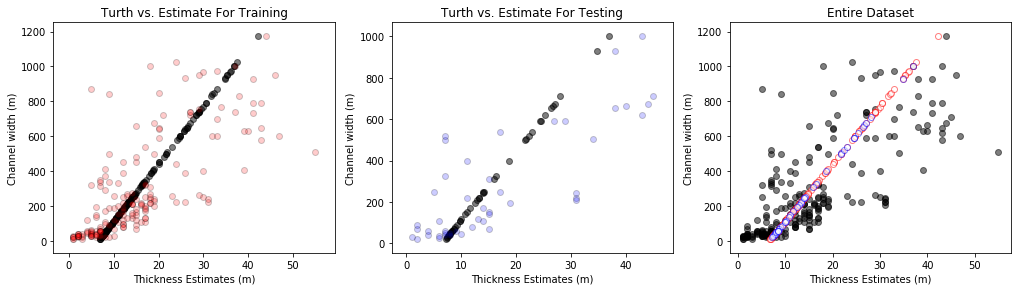

In [30]:
plt.subplot(141)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y1_train_pred,X1_train.values.reshape(n1_train,1),c='black',alpha=0.5,edgecolor='black')
plt.scatter(y1_train,X1_train.values.reshape(n1_train,1),c='red',alpha=0.2,edgecolor='black')
#plt.xlim(0,60);#plt.ylim(0,60)
plt.title('Turth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplot(142)                                                # scatter plot predictors vs predcted 
plt.scatter(y1_pred,X1_test.values.reshape(n1_test,1),c='black',alpha=0.5,edgecolor='black')
plt.scatter(y1_test,X1_test.values.reshape(n1_test,1),c='blue',alpha=0.2,edgecolor='black')#plt.plot([0,60],[0,60],c='black')
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Turth vs. Estimate For Testing'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplot(143)                                                # scatter plot predictors vs predcted 
plt.scatter(y1,X1,c='black',alpha=0.5,edgecolor='black')
plt.scatter(y1_train_pred,X1_train.values.reshape(n1_train,1),c='white',alpha=0.5,edgecolor='red')
plt.scatter(y1_pred,X1_test.values.reshape(n1_test,1),c='white',alpha=0.5,edgecolor='blue')
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Entire Dataset'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=0.8, wspace=0.2, hspace=0.1)
plt.show()

These plots are key to identify that:
```
*Our model predicts adequate depth/thickness values, thus the linear regression model 
 is not patological anymore. 
*Valid predictions are possible once we addressed multicolinearity among the predictor features
*The model explains higher variance than the model did with two features
*The model shows a score no less that 0.5 with both the training and testing dataset
```
However, It is evident from the entire dataset that that although linear regression has been the widely-used regression to represent this relationship, the heteroscadicity of the dataset could make the dataset candidate to perform a regression using other machines. Two potential candidates:

```
*Polynomial Regression could be a good candidate, which will provide flexibility to the model, allowing it to adapt better to the dataset shape. This approach will be useful for the estimated thickness/depth less than 10m 

*Decision Tree could be another candidate in order to divide the predictor's space and provide an average prediction per region. This approach will help to address the changes in variance (heteroscadicity) that the dataset exhibits.
```


### 4 Decision Tree with one predictor: 
I choose to demonstrate the Decision Tree model to address heteroscadicity in the model because although  by creating regions I add complexity, I also address the observed change in variance (heteroscadicity), which will not be addresed using polynomial regression.

#### 4.1 Create dataframe

In [31]:
Xt=df[['Channel width (m)']] 
yt=df[['Thickness (m)']]

Fair split data 20% for wihheld for testing:

In [32]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=None) # train and test split
nt_train = len(Xt_train)
nt_test = len(Xt_test)
print('Number of training ' + str(nt_train) + ', number of test ' + str(nt_test))

Number of training 181, number of test 46


#### 4.2. Instantiate the Model & Fit the Data on Training Data 1 Predictor


A general decision tree model will be run in order to evaluate how increasing the complexity will influence the change in variance explained. 

In [33]:
trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 20:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(Xt_train, yt_train)
    trees.append(my_tree)
    
    predict_train = my_tree.predict(np.c_[Xt_test['Channel width (m)']])
    
    error.append(metrics.mean_squared_error(yt_test['Thickness (m)'],predict_train))
    var_exp.append(metrics.explained_variance_score(yt_test['Thickness (m)'],predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

#### 4.3. Cross validation 
Constraining the maximum number of terminal nodes ("max_leaf_nodes") by evaluating the Performance of the decision tree model with accuracy measured as mean square error for the training data.

Apply k-fold approach with iterative separation of training and testing data on the general decision tree model with variable number of terminal nodes. 

In [34]:
score = []                     # code from StackOverFlow by Dimosthenis
node = []
for inodes in range(2,50):
    my_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores = cross_val_score(estimator=my_tree, X= np.c_[df['Channel width (m)']],y=df['Thickness (m)'], cv=3, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    node.append(inodes)

We will observe feature space as we incrementally add terminal nodes to evaluate the performance of the general decision tree model by observing the accuracy vs. complexity trade-off.

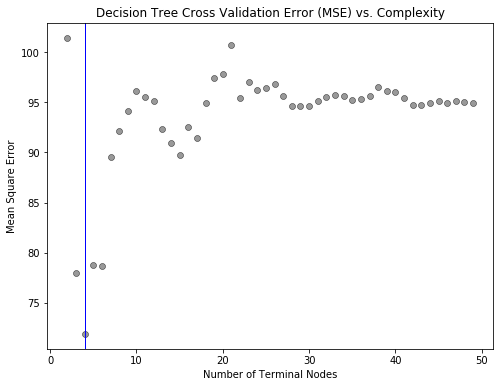

In [35]:
plt.figure(figsize=(8,6))
plt.arrow(4,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.arrow(4,0,0,1500000,width=0.02,color='blue',head_length=0.0,head_width=0.0)
plt.arrow(0,300000,90,0,width=0.02,color='green',head_length=0.0,head_width=0.0)
plt.scatter(node,score,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
#plt.xlim(0,50); plt.ylim(0,1500000)
plt.show()

I will choose max_leaf_nodes=4 because the MSE is not only the minimum but also after four, MSE increases and become chaotic

#### 4.4 Instantiate the Model & Fit the Data on Training Data 1 Predictor, after determining max_leaf_nodes

In [36]:
my_pruned_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=4)
my_pruned_tree = my_pruned_tree.fit(Xt_train, yt_train)

#visualize_tree(my_pruned_tree,X_train['Channel width (m)'],X_train['Channel W/T'],y_train['Thickness (m)'],'Training Data and Decision Tree Model')

#### 4.5.  Predictions on training dataset, Goodness of fit, Plot

Variance explained training: 52.10
Training: Average error = 0.00
Training: Standard Deviation error = 7.22


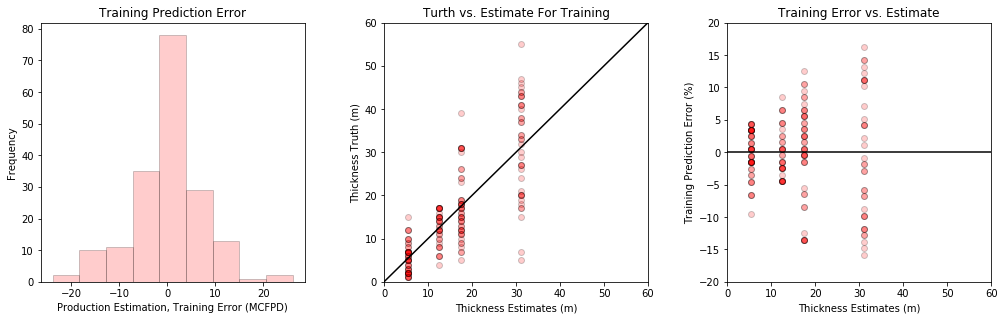

In [37]:
# Step 3: - Make predictions using the training dataset
y_train_pred_t = my_pruned_tree.predict(Xt_train.values)        # predict with the trained model at the training data samples 

# Report the goodness of fit
MSE_train_t = metrics.mean_squared_error(yt_train, y_train_pred_t)           # calculate the training MSE      
print('Variance explained training: %.2f' % MSE_train_t)

y_train_resid_t = y_train_pred_t - yt_train['Thickness (m)'].values     # calculate the residuals over the training data
print('Training: Average error = %.2f' % np.average(y_train_resid_t)) # calculate the average testing error 
print('Training: Standard Deviation error = %.2f' % np.std(y_train_resid_t)) # calculate the standard deviation testing error

plt.subplot(131)                                                # histogram of training error
plt.hist(y_train_resid_t, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(y_train_resid_t.min(),y_train_resid_t.max(),10))
plt.title('Training Prediction Error'); plt.xlabel('Production Estimation, Training Error (MCFPD)'); plt.ylabel('Frequency')
#plt.xlim(y_train_resid_t.min(),y_train_resid_t.max())#; plt.ylim(0,1500000)

plt.subplot(132)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train_pred_t,yt_train['Thickness (m)'].values,c='red',alpha=0.2,edgecolor='black')
plt.plot([0,60],[0,60],c='black')
plt.xlim(0,60); plt.ylim(0,60)
plt.title('Turth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred_t,y_train_resid_t,c='red',alpha=0.2,edgecolor='black')
plt.title('Training Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Training Prediction Error (%)')
plt.plot([0,60],[0,0],c='black')
plt.xlim(0,60); plt.ylim(-20,20)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

#### 4.6 Results Model parameters, Predictions on testing dataset, Goodness of fit, Plot

Testing: Variance explained = 48.72
Testing: Average error = 0.45
Testing: Standard Deviation error = 6.97


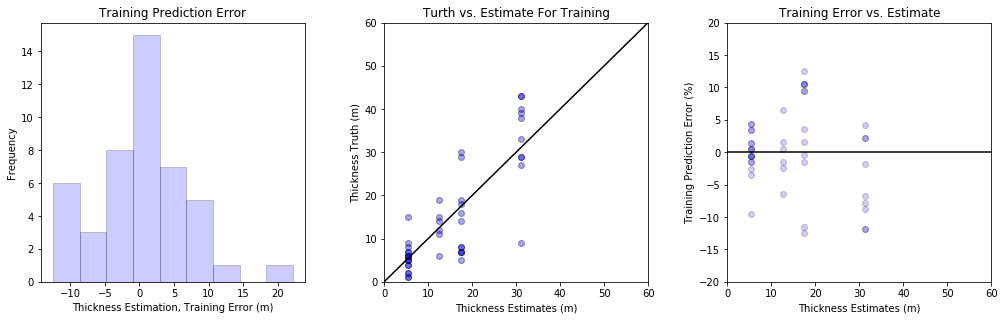

In [38]:
# Step 4: - Make predictions using the testing dataset
y_test_pred_t = my_pruned_tree.predict(Xt_test.values)        # predict with the trained model at the training data samples 


# Report the goodness of fit
MSE_test_t = metrics.mean_squared_error(yt_test, y_test_pred_t)              # calculate the testing MSE      
print('Testing: Variance explained = %.2f' % MSE_test_t)


y_test_resid_t = y_test_pred_t - yt_test['Thickness (m)'].values        # calculate the residuals over the testing data
print('Testing: Average error = %.2f' % np.average(y_test_resid_t)) # calculate the average testing error 
print('Testing: Standard Deviation error = %.2f' % np.std(y_test_resid_t)) # calculate the standard deviation testing error

plt.subplot(131)                                                # histogram of training error
plt.hist(y_test_resid_t, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(y_test_resid_t.min(),y_test_resid_t.max(),10))
plt.title('Training Prediction Error'); plt.xlabel('Thickness Estimation, Training Error (m)'); plt.ylabel('Frequency')
#plt.xlim(y_test_resid_t.min(),y_test_resid_t.max(),)#; plt.ylim(0,1500000)

plt.subplot(132)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test_pred_t,yt_test['Thickness (m)'].values,c='blue',alpha=0.2,edgecolor='black')
plt.scatter(y_test_pred_t,yt_test['Thickness (m)'].values,c='blue',alpha=0.2,edgecolor='black')
plt.plot([0,60],[0,60],c='black')
plt.xlim(0,60); plt.ylim(0,60)
plt.title('Turth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Thickness Truth (m)')

plt.subplot(133)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred_t,y_test_resid_t,c='blue',alpha=0.2,edgecolor='black')
plt.title('Training Error vs. Estimate'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Training Prediction Error (%)')
plt.plot([0,60],[0,0],c='black')
plt.xlim(0,60); plt.ylim(-20,20)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

Bivariate plots of Estimated/predicted values vs Predictors

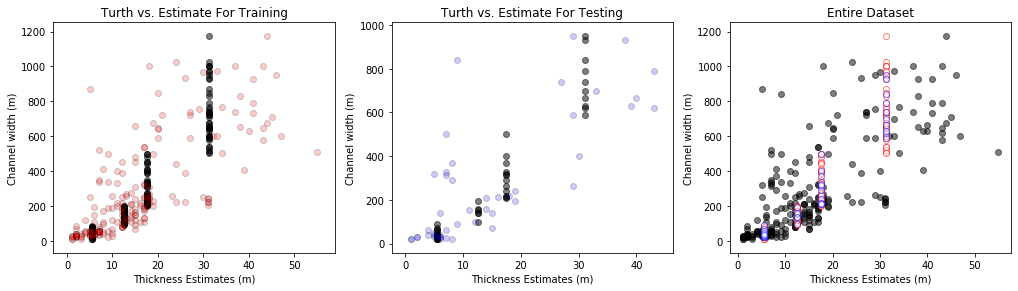

In [39]:
plt.subplot(141)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train_pred_t,Xt_train.values.reshape(nt_train,1),c='black',alpha=0.5,edgecolor='black')
plt.scatter(yt_train,Xt_train.values.reshape(nt_train,1),c='red',alpha=0.2,edgecolor='black')
#plt.xlim(0,60);#plt.ylim(0,60)
plt.title('Turth vs. Estimate For Training'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')


plt.subplot(142)                                                # scatter plot predictors vs predcted 
plt.scatter(y_test_pred_t,Xt_test.values.reshape(nt_test,1),c='black',alpha=0.5,edgecolor='black')
plt.scatter(yt_test,Xt_test.values.reshape(nt_test,1),c='blue',alpha=0.2,edgecolor='black')#plt.plot([0,60],[0,60],c='black')
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Turth vs. Estimate For Testing'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplot(143)                                                # scatter plot predictors vs predcted 
plt.scatter(yt,Xt,c='black',alpha=0.5,edgecolor='black')
plt.scatter(y_train_pred_t,Xt_train.values.reshape(nt_train,1),c='white',alpha=0.5,edgecolor='red')
plt.scatter(y_test_pred_t,Xt_test.values.reshape(nt_test,1),c='white',alpha=0.5,edgecolor='blue')
#plt.xlim(0,60); plt.ylim(0,60)
plt.title('Entire Dataset'); plt.xlabel('Thickness Estimates (m)'); plt.ylabel('Channel width (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=0.8, wspace=0.2, hspace=0.1)
plt.show()

*These plots are indicating that although we decrease model variance, we were able 
 to address the homoscedacity in the dataset by increasing model complexity. 

*The model succesfully captures homoscedasticity in the dataset by assigning to different regions the areas with  
 variance difference

### Parting Comments 
```
*This is a brief workflow that addresses the impact of multicolinearity among the predictors. We observed its   
 impact on the model accuracy and variance explained.
 
*This workflow also challenged the widely accepted belief that river thickness and river width relationship is 
 well explained by a linear regression. However, we are demonstrating that heteroscadicity could potentially 
 complicate prediction estimation models. 
 
*We also highlighted how faithful and efficient feature ranking coefficients were in demonstrating   
 multicolinearity. 
```


E. Gabriela Gutierrez
```
Expertise, Geosciences: Geochronology, Sedimentary Basins, Tectonics, Sedimentology  
Amateur Data Scientist
```
 ##### [Profile](https://www.jsg.utexas.edu/student/evelin_gutierrez/)   | [LinkedIn](https://www.linkedin.com/in/gabriela-gutierrez-3259a057/) 

#### Acknowledgements: 

```
Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
*90% of the code used in this workflow was developed by:
```
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | 
```
*Remaining 10% of the code was written by external authors properly cited in external functions 
```